In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pos = pd.read_csv('F:\\Downloads\\dseb-63-data-preparation-final-project\\dseb63_final_project_DP_dataset\\dseb63_pos_cash_balance.csv')


## POS Cash Balance

In [3]:
pos

,SK_ID_PREV,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,SK_ID_CURR
0,1803195,-31,48.0,45.0,Active,0,0,185279
1,1803195,-17,48.0,31.0,Active,0,0,185279
2,1803195,-21,48.0,35.0,Active,0,0,185279
3,1803195,-8,48.0,21.0,Active,0,0,185279
4,1803195,-4,48.0,17.0,Active,0,0,185279
...,...,...,...,...,...,...,...,...
8543370,2340627,-2,NaN,NaN,Signed,0,0,284649
8543371,1011796,-2,6.0,6.0,Active,0,0,69172
8543372,1298851,-1,12.0,12.0,Active,0,0,151122
8543373,1550592,-1,1.0,0.0,Completed,0,0,56549


## Null Values Count

In [4]:
pos.isnull().sum()

SK_ID_PREV                   0
MONTHS_BALANCE               0
CNT_INSTALMENT           21863
CNT_INSTALMENT_FUTURE    21878
NAME_CONTRACT_STATUS         0
SK_DPD                       0
SK_DPD_DEF                   0
SK_ID_CURR                   0
dtype: int64

## Null Values Percentage

In [5]:
(pos.isnull().sum()/pos.shape[0]) * 100

SK_ID_PREV               0.000000
MONTHS_BALANCE           0.000000
CNT_INSTALMENT           0.255906
CNT_INSTALMENT_FUTURE    0.256081
NAME_CONTRACT_STATUS     0.000000
SK_DPD                   0.000000
SK_DPD_DEF               0.000000
SK_ID_CURR               0.000000
dtype: float64

## Columns' Distribution

array([[<Axes: title={'center': 'MONTHS_BALANCE'}>,
        <Axes: title={'center': 'CNT_INSTALMENT'}>],
       [<Axes: title={'center': 'CNT_INSTALMENT_FUTURE'}>, <Axes: >]],
      dtype=object)

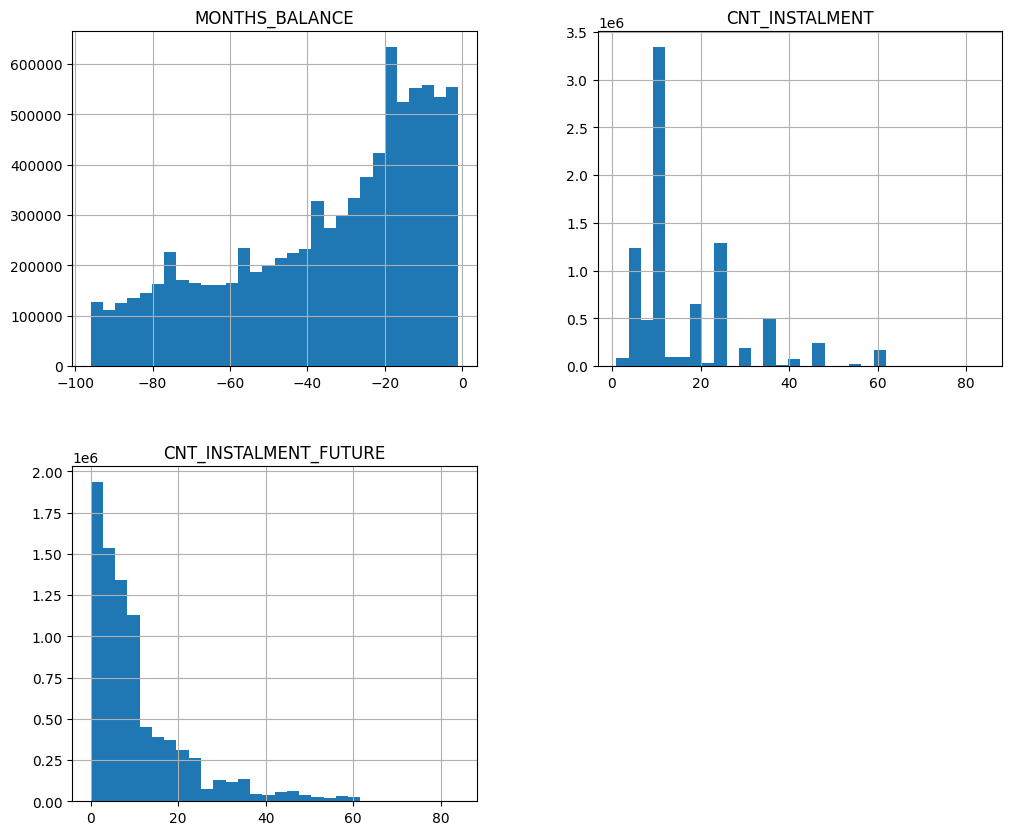

In [6]:
X_pos = pos.iloc[:,1:-4]
X_pos.hist(bins=30, figsize=(12,10))

## Outliers Check

<Axes: >

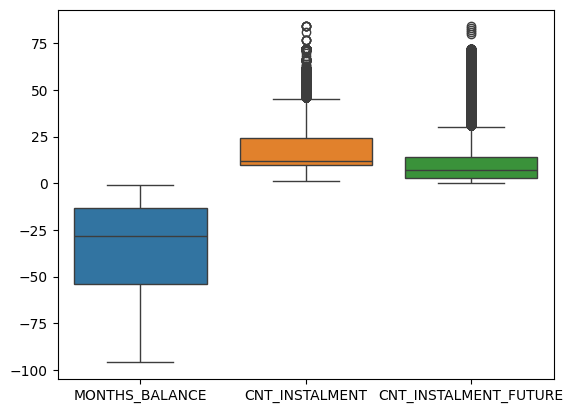

In [7]:
sns.boxplot(pos[['MONTHS_BALANCE','CNT_INSTALMENT','CNT_INSTALMENT_FUTURE']])